In [2]:
!pip install healpy
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import healpy as hp
import cv2
import math

In [4]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

FOV = [math.pi/4, math.pi/4 * 0.56206896551]
OFFSET = [math.pi/2, 0]

In [5]:
# Map pixels to RA and DEC values (theta and phi)
def register_pixels(img, off):
    height, width = img.shape

    print(f"Image shape: {img.shape}")

    out = []

    for y in range(height):
        for x in range(width):
            theta = (y - height//2) * FOV[0] / height
            phi = (x - width//2) * FOV[1] / width

            out.append((theta + off[0], phi + off[1], img[y, x]))

    return out

# Determine all overlapping spherical pixels from a pixel's center angle
def find_overlapping_pixels(angle, width, height):
    pixel_size_x = FOV[1] / width
    pixel_size_y = FOV[0] / height

    vecs = np.array([
        hp.ang2vec((angle[0] - pixel_size_y/2) % math.pi, (angle[1] - pixel_size_x/2) % 2*math.pi),
        hp.ang2vec((angle[0] + pixel_size_y/2) % math.pi, (angle[1] - pixel_size_x/2) % 2*math.pi),
        hp.ang2vec((angle[0] + pixel_size_y/2) % math.pi, (angle[1] + pixel_size_x/2) % 2*math.pi),
        hp.ang2vec((angle[0] - pixel_size_y/2) % math.pi, (angle[1] + pixel_size_x/2) % 2*math.pi),
    ])

    return hp.query_polygon(NSIDE, vecs)

# Perform bilinear interpolation on spherical pixels referencing the original image
def bilinear_interpolation(pix, img, off):
    height, width = img.shape

    center = hp.pix2ang(NSIDE, pix)

    # m = np.zeros(NPIX)

    # m[pix] = 1

    # hp.mollview(m, title="Mollview image RING")
    # hp.graticule()

    theta = center[0] - off[0] + FOV[0]/2
    phi = center[1] - off[1] + FOV[1]/2

    print(f"Updated theta, phi: {(theta, phi)}")

    y = (theta * height / FOV[0]) + height // 2
    x = (phi * width / FOV[1]) + width // 2

    print(f"x: {x}, y: {y}")

    x_ceil = min(width - 1, math.ceil(x))
    x_floor = max(math.floor(x), 0)
    y_ceil = min(width - 1, math.ceil(y))
    y_floor = max(math.floor(y), 0)

    v1 = img[y_floor, x_floor]

    v2 = img[y_floor, x_ceil]
    v3 = img[y_ceil, x_ceil]
    v4 = img[y_ceil, x_floor]

    if x_ceil == x_floor and y_ceil == y_floor:
        return img[y_floor, x_floor]
    if x_ceil == x_floor:
        return v1 * (y_ceil - y) + v3 * (y - y_floor)
    if y_ceil == y_floor:
        return v1 * (x_ceil - x) + v2 * (x - x_floor)
    else:
        q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
        q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
        return q1 * (y_ceil - y) + q2 * (y - y_floor)

def plot_sphere(pts):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color='lightgray', alpha=0.3)

    ax.view_init(elev=180, azim=0)

    plt.quiver(np.zeros(9), np.zeros(9), np.zeros(9), pts[:,0], pts[:,1], pts[:,2], length=1, normalize=True, color='r')

    plt.show()

(326, 580)
Image shape: (326, 580)


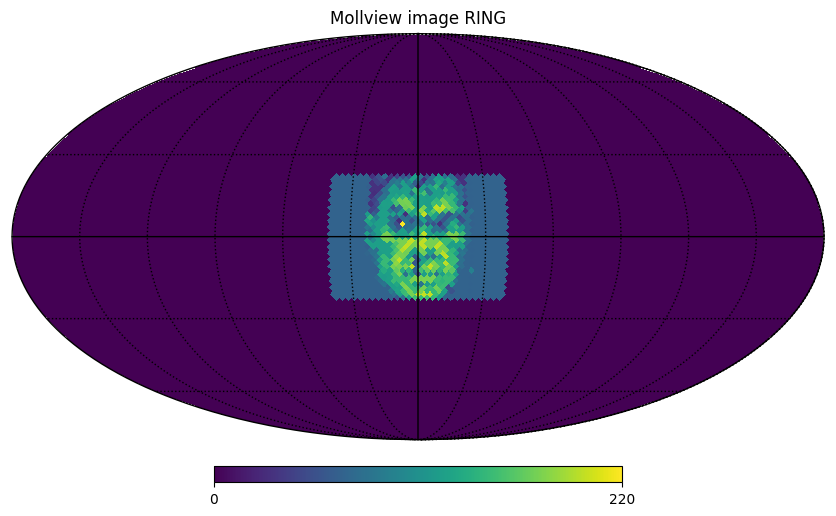

In [6]:
img = cv2.imread("guy.jpg")
# img = cv2.resize(img, (0,0), fx=0.1, fy=0.1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# img = np.array([

#     [1]
# ])

# img = np.array([
#     [0, 0.5, 0],
#     [0.5, 1, 0.5],
#     [0, 0.5, 0]
# ])

# img = np.array([
#     [0, 0, 1, 1, 1, 0, 0],
#     [0, 0, 1, 0, 1, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0]
# ])

print(img.shape)

height, width = img.shape

m = np.zeros(NPIX)

angles = register_pixels(img, OFFSET)

sp = set()

for angle in angles:
    # m[hp.ang2pix(NSIDE, angle[0], angle[1])] = angle[2]
    # pts.append(hp.ang2vec(angle[0], angle[1]))
    # print(hp.ang2vec(angle[0], angle[1]))
    res = find_overlapping_pixels(angle, width, height)
    sp.update(res)
    m[res] = angle[2]
    # spi.update(sp.intersection(res))
    # sp.update(res)

# pts = np.array(pts)

# print(pts)

hp.mollview(m, title="Mollview image RING")
# hp.mollzoom(m, title="Mollview image RING", xsize=8000)
hp.graticule()

# plot_sphere(pts)

# m2 = np.zeros(NPIX)

# for p in sp:
#     try:
#         m2[p] = bilinear_interpolation(p, img, OFFSET)
#         print(m2[p])
#     except Exception as e:
#         print(e)
#         continue

# for p in sp:
#     try:
#         m2[p] = bilinear_interpolation(p, img, OFFSET)
#         # print(m2[p])
#     except Exception as e:
#         print(e)
#         continue

# hp.mollview(m2, title="Mollview image RING")
# hp.graticule()

# m3 = np.zeros(NPIX)

# for p in spi:
#     try:
#         m3[p] = bilinear_interpolation(p, img, FOV, OFFSET)
#         # print(m2[p])
#     except Exception as e:
#         print(e)
#         continue

# hp.mollview(m3, title="Mollview image RING")
# hp.graticule()


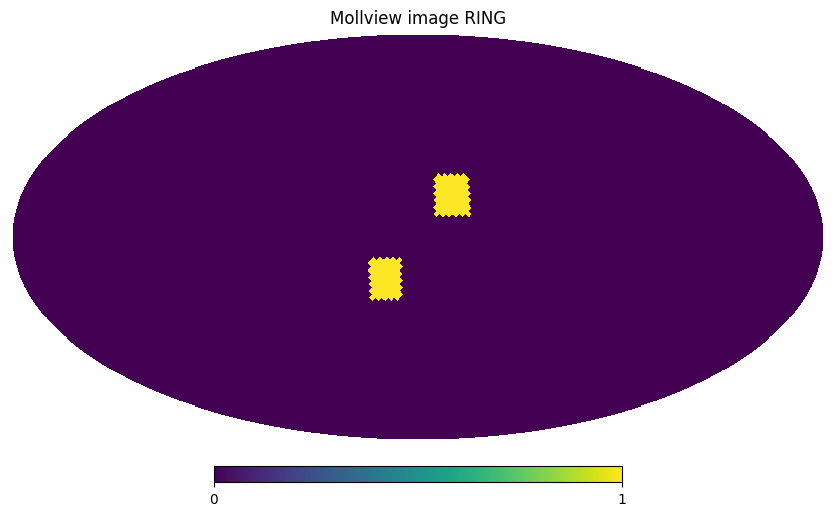

In [7]:
# mp = hp.read_map("../src/output.fits")

mp = np.zeros(NPIX)

colored = hp.query_polygon(hp.get_nside(mp), np.array([
    hp.ang2vec(1.178097, 5.890486),
    hp.ang2vec(1.439897, 5.890486),
    hp.ang2vec(1.439897, 6.152286),
    hp.ang2vec(1.178097, 6.152286)
]))

colored = hp.query_polygon(hp.get_nside(mp), np.array([
    hp.ang2vec(1.178097, 5.890486),
    hp.ang2vec(1.439897, 5.890486),
    hp.ang2vec(1.439897, 6.152286),
    hp.ang2vec(1.178097, 6.152286)
]))


colored2 = hp.query_polygon(hp.get_nside(mp), np.array([
    hp.ang2vec(1.178097, 6.152286),
    hp.ang2vec(1.439897, 6.152286),
    hp.ang2vec(1.439897, 0.130900),
    hp.ang2vec(1.178097, 0.130900)
]))

colored3 = hp.query_polygon(hp.get_nside(mp), np.array([
    hp.ang2vec(1.701696, 0.130900),
    hp.ang2vec(1.963495, 0.130900),
    hp.ang2vec(1.963495, 0.392699),
    hp.ang2vec(1.701696, 0.392699)
]))


mp[colored] = 1

# mp[colored2] = 1

mp[colored3] = 1

hp.mollview(mp, title="Mollview image RING")

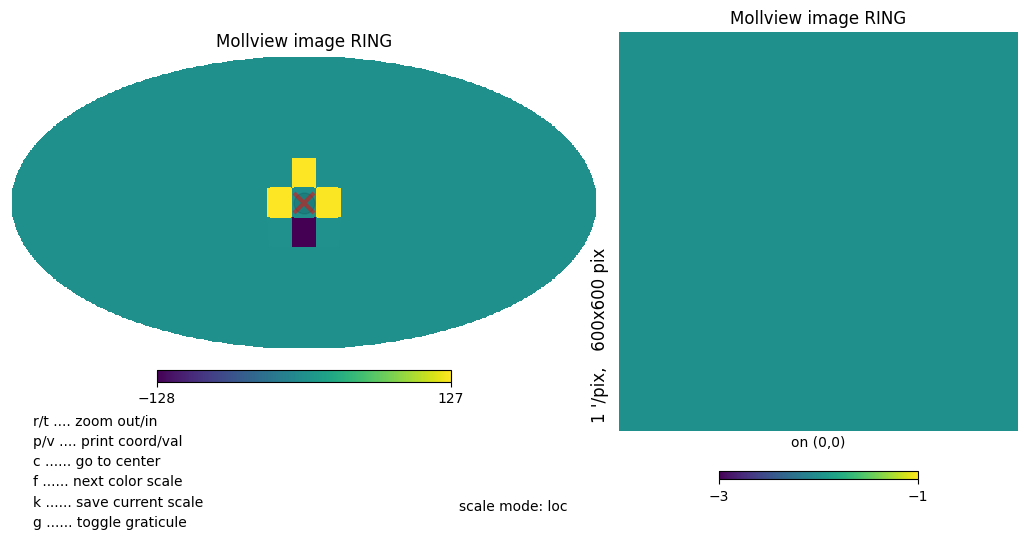

In [14]:
mp = hp.read_map("../src/output.fits")

# mp = np.zeros(NPIX)

# colored = hp.query_polygon(hp.get_nside(mp), np.array([
#     hp.ang2vec(theta=1.178097, phi=5.890486),
#     hp.ang2vec(theta=1.963495, phi=5.890486),
#     hp.ang2vec(theta=1.963495, phi=0.392699),
#     hp.ang2vec(theta=1.178097, phi=0.392699)
# ]))

# mp[colored] = 1

hp.mollzoom(mp, title="Mollview image RING")

In [9]:
# img = np.array([
#     [0, 127, 0],
#     [127, 255, 127],
#     [0, 127, 0]
# ])

img = np.asarray([
    np.asarray([255 if (i % 2 == 0 and x % 2 == 0) else 0 for i in range(0, 10)])
    for x in range(0, 10)
])

cv2.imwrite("../src/image.jpg", img)

[ WARN:0@9.822] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


True

In [26]:
img = np.asarray([
    np.asarray([255 for i in range(0, 100)])
    for x in range(0, 100)
])

cv2.imwrite("../src/image.jpg", img)

True

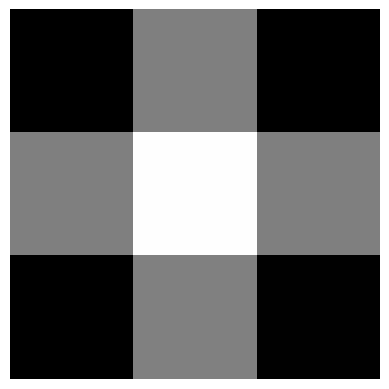

True

In [10]:
img = cv2.imread("../src/image.jpg")

image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')  # Optional: remove axes and ticks
plt.show()

cv2.imwrite("image.jpg", img)